# **Black-Litterman Model**
**Description:** This project implements the Black-Litterman model to construct an optimal asset allocation strategy. It leverages news sentiment analysis across financial, and macroeconomic themes to generate views, which are then incorporated into the Black-Litterman framework.


**Objective:** The goal is to dynamically adjust portfolio weights based on real-time market narratives and expert opinions derived from news data, aiming to enhance traditional mean-variance optimization.


**Motivation:** Traditional mean-variance optimization relies on historical returns, which may not reflect real-time investor beliefs or emerging market signals. The Black-Litterman model addresses this by combining market-implied equilibrium returns with subjective views — such as those derived from news sentiment or expert forecasts — in a mathematically consistent way. This project extends that framework by generating these views through sentiment analysis of current financial narratives.

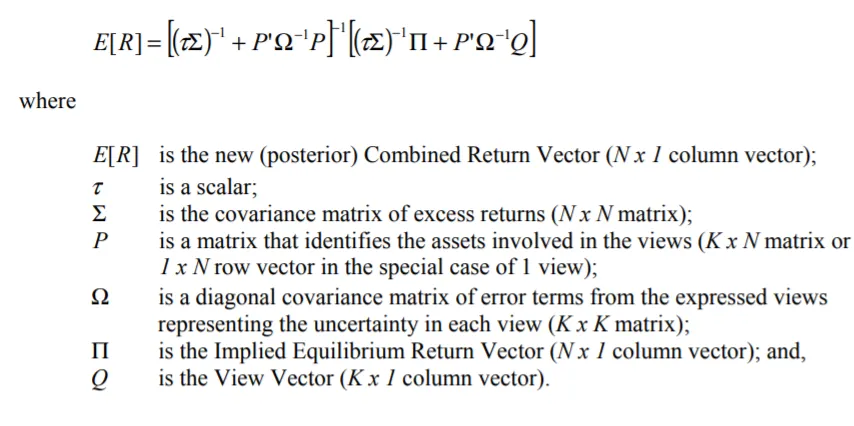

In this implementation of the Black-Litterman model, investor views are derived from news sentiment analysis using natural language processing (NLP). These views are incorporated into the model through `Q`, and `Ω` matrices as follows:

- **`Q` (View Vector):** Specifies the magnitude of the expected return or return difference based on the sentiment score extracted from news. For example, a strongly positive sentiment score may translate to a +5% expected return for a particular asset.

- **`Ω` (View Uncertainty Matrix):** Represents the confidence in each view. This is quantified based on factors like the consistency of sentiment, volume of supporting articles, or credibility of sources. Higher confidence results in a lower variance in `Ω`, giving more weight to that view in the final return estimation.

In [ ]:
%pip install newsapi-python yfinance pymc

# Import necessary libraries
from newsapi import NewsApiClient
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
from time import sleep
import yfinance as yf
import pymc as pm
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import os

In [ ]:
# Initialize NewsAPI client
api_key = os.environ.get("NEWS_API_KEY")
newsapi = NewsApiClient(api_key=api_key)

# Load FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Define ticker symbols
tickers = ["XLK", "XLE", "XLF", "TLT", "TIP", "GLD"]

### ETF Tickers Used for Sector Allocation Strategy

The following ETF ticker symbols are selected to represent major sectors and asset classes in the U.S. financial market. They form the investment universe for the Black-Litterman model.

By analysing news sentiment related to each ETF, we can estimate which sectors are expected to perform well (positive sentiment) or poorly (negative sentiment). This allows the model to suggest a **broad asset allocation strategy** — helping investors decide **which sectors to invest in or stay cautious about**, based on real-time market narratives.

| Ticker | Description                             | Sector / Asset Class             |
|--------|-----------------------------------------|----------------------------------|
| `XLK`  | Technology Select Sector SPDR Fund      | **Technology stocks**            |
| `XLE`  | Energy Select Sector SPDR Fund          | **Energy stocks**                |
| `XLF`  | Financial Select Sector SPDR Fund       | **Financial stocks**             |
| `TLT`  | iShares 20+ Year Treasury Bond ETF      | **Long-term U.S. Treasury bonds**|
| `TIP`  | iShares TIPS Bond ETF                   | **Inflation-protected bonds**    |
| `GLD`  | SPDR Gold Shares                        | **Gold (commodity hedge)**       |


In [ ]:
custom_keywords = {
    "Technology": ["AI", "semiconductors", "cloud computing", "software"],
    "Energy": ["oil", "natural gas", "renewable energy", "carbon"],
    "Financials": ["banks", "interest rates", "credit", "insurance"],
    "Bonds": ["treasury yields", "interest rates", "Fed policy"],
    "Gold": ["gold price", "safe haven", "inflation hedge"]
}

# Generate search queries based on Sector & Custom keywords
def generate_queries(ticker):
    info = yf.Ticker(ticker).info
    sector = info.get("category", "")

    custom = custom_keywords.get(sector, [])
    keywords = [ticker, sector] + custom
    return ' OR '.join([f'"{kw}"' for kw in keywords if kw])


# Fetch news titles based on the keywords
def fetch_news(query, page_size=20):
    try:
        articles = newsapi.get_everything(q=query,
                                          language='en',
                                          sort_by='relevancy',
                                          page_size=page_size)
        return [a['title'] for a in articles['articles'] if a['title']]
    except Exception as e:
        print(f"News fetch failed for query: {query}\n{e}")
        return []

generate_queries("XLK")

In [ ]:
# FinBert Sentiment scoring
def analyze_sentiment(texts):
    scores = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            score = probs[0][2].item() - probs[0][0].item()  # pos - neg
            scores.append(score)
    return scores

# Example
print(analyze_sentiment("Nvidia's stock market value hits $4 trillion on AI dominance"))

In [ ]:
# Compute 1-month forward returns
def get_forward_return(ticker, start="2024-05-01", period_days=30):
    etf = yf.Ticker(ticker)
    df = etf.history(start=start, end=None)

    # Ensure there are enough data points
    if len(df) < period_days:
        return None

    # Get close price at t0 and t+30
    t0_close = df['Close'].iloc[0]
    t1_close = df['Close'].iloc[min(period_days, len(df)-1)]

    # Calculate % return
    return_pct = (t1_close - t0_close) / t0_close
    return return_pct

historical_returns = {}

for t in tickers:
    r = get_forward_return(t, start="2024-05-01", period_days=30)
    if r is not None:
        historical_returns[t] = r

print(historical_returns)

### Estimating alpha using Bayesian regression instead of a fixed scalar

In a typical Black-Litterman implementation, we might use a fixed scalar (e.g. `0.1`) to convert sentiment scores into expected returns. For example, if an ETF had a sentiment score of `0.3`, we’d manually set the expected return to `0.03` (0.1 × 0.3). While simple, this approach assumes we already know how strongly sentiment influences returns — and that the relationship is the same across all assets and time periods.

Instead of assuming this, we take a more data-driven approach here.

We collect real data: average sentiment scores (from FinBERT) and actual 1-month forward returns (from historical prices). Then, we use **Bayesian linear regression** to estimate the `alpha` coefficient — which represents how much return changes, on average, for every unit change in sentiment.

The benefit of this approach is two-fold:
- We get a **mean value** for alpha (used to compute expected return `Q`)
- We also get a **standard deviation** for alpha (used to inform uncertainty in `Ω`)

In [ ]:
def estimate_alpha(sentiment_dict, historical_returns):
    avg_sentiments = []
    forward_returns = []

    for t in sentiment_dict:
        sentiments = sentiment_dict[t]
        r = historical_returns.get(t, None)
        if sentiments and r is not None:
            avg_sentiments.append(np.mean(sentiments))
            forward_returns.append(r)

    X = np.array(avg_sentiments)
    y = np.array(forward_returns)

    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        mu = alpha * X
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True, progressbar=False)

    alpha_mean = trace.posterior["alpha"].mean().item()
    return alpha_mean

# Example
test_sentiment_dict = {
    "XLK": [0.1, 0.2, 0.15],
    "XLF": [-0.05, 0.0, 0.1],
    "XLE": [0.03, 0.04, 0.02]
}

test_historical_returns = {
    "XLK": 0.08,
    "XLF": 0.01,
    "XLE": 0.03
}

# Run the function and print the result
alpha_test = estimate_alpha(test_sentiment_dict, test_historical_returns)
print(f"Test alpha from dummy data: {alpha_test:.4f}")

In [ ]:
def construct_view_matrices(sentiment_dict, alpha):
    Q = []
    Omega = []

    for ticker, scores in sentiment_dict.items():
        if scores:
            avg_score = np.mean(scores)
            expected_return = alpha * avg_score
            variance = max(1e-6, np.var(scores))
        else:
            expected_return = 0.0
            variance = 0.1

        Q.append(expected_return)
        Omega.append([variance])

    Q = np.array(Q).reshape(-1, 1)
    Omega = np.diagflat(Omega)
    P = np.identity(len(Q))

    return Q, Omega, P

# Example
Q, Omega, P = construct_view_matrices(test_sentiment_dict, alpha=alpha_test)
print("Q (Expected Returns):\n", Q)

print("\nOmega (Uncertainty Matrix):\n", Omega)

print("\nP (Pick Matrix):\n", P)

In [ ]:
def get_market_caps(tickers):
    weights = []
    for t in tickers:
        try:
            info = yf.Ticker(t).info
            mc = info.get("totalAssets") or info.get("marketCap")
            weights.append(mc if mc else 0)
        except:
            weights.append(0)
    weights = np.array(weights, dtype=np.float64)
    weights = weights / weights.sum()  # Normalize to sum to 1
    return weights

print(get_market_caps(tickers))

In [ ]:
def run_black_litterman(Q, Omega, P, Pi, Sigma, lambda_risk=2.5, tau=0.05):
    inv_tau_Sigma = np.linalg.inv(tau * Sigma)
    inv_Omega = np.linalg.inv(Omega)
    middle = np.linalg.inv(inv_tau_Sigma + P.T @ inv_Omega @ P)
    right = inv_tau_Sigma @ Pi.reshape(-1, 1) + P.T @ inv_Omega @ Q
    posterior_returns = middle @ right
    weights = np.linalg.inv(lambda_risk * Sigma) @ posterior_returns
    weights = weights / weights.sum()
    return weights.flatten(), posterior_returns.flatten()


### Backtesting allocation strategy

The backtest will start from May 2024 to May 2025. The portfolio is rebalanced at the start of each month based on updated sentiment and risk data.

At each rebalancing point, we:

*   Calculate the past 12 months of ETF price data to estimate the covariance matrix (risk).
*   Collect news headlines for each ETF and score them using FinBERT to measure sentiment.
*   Estimate the relationship between sentiment and forward returns using Bayesian regression
*   Construct views from sentiment and combine them with market equilibrium returns using the Black-Litterman model to generate new portfolio weights.

These weights are then applied to the actual returns of the following month. The cumulative portfolio return is tracked across the backtest period to evaluate overall performance.

In [ ]:
lambda_risk = 2.5 # Risk aversion coefficient (used in equilibrium return calculation)
tau = 0.05        # Scalar indicating uncertainty in the prior (used in BL model)
start_date = pd.to_datetime("2024-05-01")
end_date = pd.to_datetime("2025-05-01")
dates = pd.date_range(start=start_date, end=end_date, freq="MS")

# Download all historical price data needed for the entire period
full_prices = yf.download(tickers, start=start_date - relativedelta(months=12), end=end_date)["Close"]

cumulative_value = 1.0
cumulative_returns = []

# Loop through each monthly rebalancing window
for i in range(len(dates) - 1):
    rebalance_date = dates[i]
    next_date = dates[i + 1]

    # Calculate the covariance matrix from the trailing 12-month returns
    price_window = full_prices.loc[rebalance_date - relativedelta(months=12):rebalance_date]
    returns = price_window.pct_change().dropna()
    cov_matrix = returns.cov()
    Sigma = cov_matrix.values

    # Based on the CAPM logic: Pi = λ * Σ * w_market
    market_weights = get_market_caps(tickers)
    Pi = lambda_risk * cov_matrix.dot(market_weights)

    # Build sentiment-based investor views for this month
    sentiment_dict = {}
    return_dict = {}
    for t in tickers:
        query = generate_queries(t)
        titles = fetch_news(query)
        sentiments = analyze_sentiment(titles)
        sentiment_dict[t] = sentiments

        # Compute actual 1-month forward return to train alpha later
        r = get_forward_return(t, start=rebalance_date.strftime("%Y-%m-%d"), period_days=30)
        return_dict[t] = r

    # Estimate alpha (sentiment-to-return coefficient) using Bayesian regression
    alpha = estimate_alpha(sentiment_dict, return_dict)
    Q, Omega, P = construct_view_matrices(sentiment_dict, alpha)
    weights, _ = run_black_litterman(Q, Omega, P, Pi.values, Sigma)

    # Apply the new weights to next month's actual returns
    price_next = full_prices.loc[next_date:next_date + relativedelta(months=1)]
    returns_next = price_next.pct_change().dropna()
    if not returns_next.empty:
        portfolio_returns = returns_next @ weights
        for r in portfolio_returns:
            cumulative_value *= (1 + r)
            cumulative_returns.append(cumulative_value)

In [ ]:
plt.plot(cumulative_returns)
plt.title("Black-Litterman Monthly Rebalanced Portfolio")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

### Sharpe Ratio to evaluate allocation strategy

The Sharpe Ratio is a widely used metric to evaluate the risk-adjusted return of an investment. It helps answer a key question:

> *Is the portfolio generating good returns relative to the risk taken?*

In this backtest, we use the Sharpe Ratio to assess whether our monthly sentiment-driven Black-Litterman portfolio delivered efficient returns between May 2024 and May 2025, based on daily returns and assuming a 3% annual risk-free rate.

To capture how performance evolved over time, we also compute a rolling Sharpe Ratio using a 21-day window (roughly one trading month). This allows us to observe short-term fluctuations in risk-adjusted returns across the year, especially since the portfolio is rebalanced monthly in response to changing sentiment.

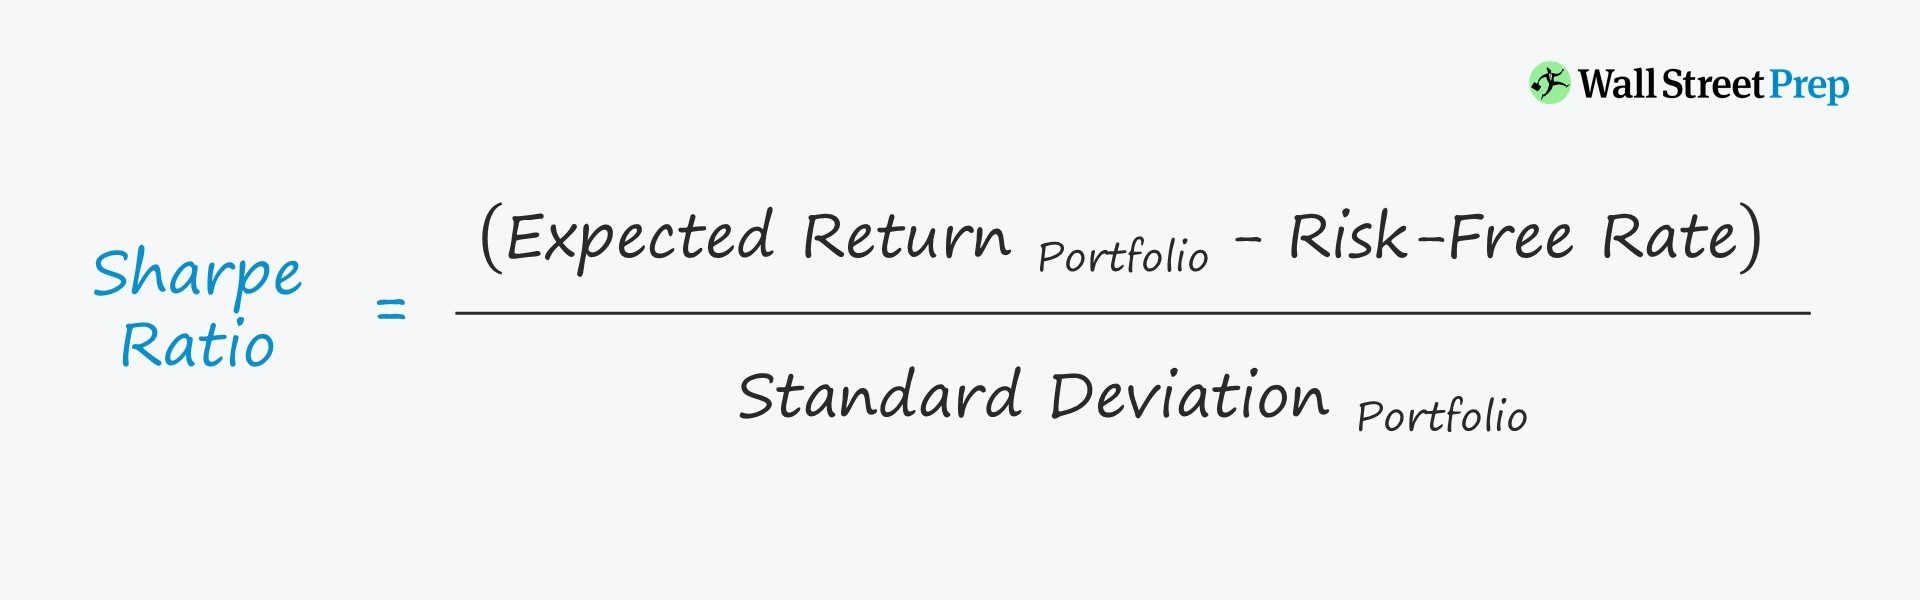

In [ ]:
window = 21  # 1 month of trading days
rf_daily = 0.03 / 252

# Daily returns
daily_returns = pd.Series(cumulative_returns).pct_change().dropna()
excess_returns = daily_returns - rf_daily

# Rolling Sharpe Ratio
rolling_sharpe = excess_returns.rolling(window).mean() / excess_returns.rolling(window).std()
rolling_sharpe = rolling_sharpe * np.sqrt(252)

# Plot
plt.figure(figsize=(10, 4))
rolling_sharpe.plot()
plt.title("Rolling Sharpe Ratio (21-day window)")
plt.xlabel("Days")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()